
# IPAN - ImageJ Processing Assistant Notebook

## 02 - Working with ImageJ pt.2
**PlugIns and generalized macro functions**

***
### Import Libraries and packages 

In [1]:
import scyjava                    # {optional} Set memory pool
from skimage import io            # ImageJ opener, open the image on the background ImageJ
from IPython.display import Image # Display only images
import os                         # Used to manipulate and create directory with python.
import tifffile                   # Save .tif files from numpy arrays

***

### Import ImageJ

By default, the ImageJ2 gateway will not include the legacy layer for backwards compatibility with the original ImageJ. The legacy layer is necessary for macros and any ImageJ-based plugins. 
In order to use original ImageJ macros, plugins, or other code you must initiate the environment with **legacy supported** (second argument of the imagej initialization). If in doubt, you can check the ij.legacy().isActive() function to see if your initialization worked properly. 
With the following initialization we can work with ImageJ1 plugins with a stable annd fixed version of the software (first argument of the imagej initialization). 
In alternative (shown belox a text), we can import the desired list of plugins from a local repository.

Run the imageJ initilization **only 1 time**, otherwie the legacy state becomes inactive

In [2]:
%%capture test
## Change the memory pool if required
#scyjava.config.add_options('-Xmx2g') # <--- Example: set 2G memory.

#The initialization of ImageJ with the following arguments returna mulitple warnings massages
#but they do not affect the functionality of the notebook. 

import imagej
ij = imagej.init(['sc.fiji:fiji:2.0.0-pre-10', 'net.imagej:imagej-legacy'])

log4j:WARN No appenders could be found for logger (org.bushe.swing.event.EventService).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.


23:37:22.344 [SciJava-1126de6f-Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.SlideBook6Reader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:352)
	at java.lang.Class.forName0(Native Method)
	at java.lang.Class.forName(Class.java:264)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
	at loci.formats.ClassList.<init>(ClassList.java:122)
	at loci.formats.ImageReader.getDefaultReaderClasses(ImageReader.java:79)
	at io.scif.bf.BioFormatsFormat.cacheReaderClasses(BioFormatsFormat.java:489)
	at io.scif.bf.BioFormatsFormat.<init>(BioFormatsFormat.java:138)
	at sun.reflect.NativeConstructorAccesso

In [3]:
print("The actual version of ImageJ is:", ij.getApp().getInfo(True))

The actual version of ImageJ is: ImageJ 2.0.0-rc-71/1.52i; Java 1.8.0_302 [x86_64]; 47MB of 910MB


ALTERNATIVE initialization (make it a code chunk to run):

#Upload local plugins

plugins_dir = '/Applications/Fiji.app/plugins'

scyjava.config.add_option(f'-Dplugins.dir={plugins_dir}')

#Initialize ImageJ with legacy for retrocompatibility with IMAGEJ1

ij = imagej.init(['net.imagej:imagej', 'net.imagej:imagej-legacy'])

With the forollowing command we can ask if the legagy for retrocompatibility is active. To run this notebook is essential that the legacy is ACTIVE.

In [4]:
print("Legacy state is active:\t", ij.legacy.isActive())

Legacy state is active:	 True


***
### Run a PLUG IN to process the image

#### Filters

Open the image within a Macro and show it to screen

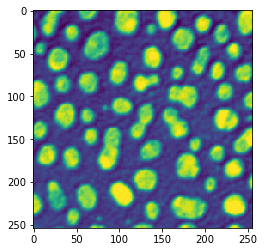

In [5]:
ij.py.run_macro("""run("Blobs (25K)");""")  # Open the sample blob image
blobs = ij.py.active_image_plus()           # Assign it to a JN varible
ij.py.show(blobs)

Run a plugin mean (IJ1 plugin) and display the result to screen

In [6]:
plugin = 'Mean'
args = {
    'block_radius_x': 10,
    'block_radius_y': 10            
}
ij.py.run_plugin(plugin, args)

<java object 'org.scijava.script.ScriptModule'>

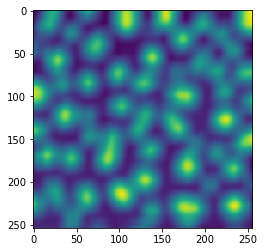

In [7]:
filtered_blobs = ij.py.active_image_plus()
ij.py.show(filtered_blobs)

Perform the image processing filter on a local image previously opened with the macro

In [8]:
#DEFINE INPUT AND OUTPUT
cwd = os.getcwd() #Get current directory
IMAGES_dir = cwd + "/IMAGES"
RESULTS_dir = cwd + "/RESULTS"

try:
    os.mkdir(RESULTS_dir)  
except FileExistsError:
    print("This directory already exist!")
    
print("The images are imported from: ", IMAGES_dir)
print("The results are exported in: ", RESULTS_dir)

This directory already exist!
The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/RESULTS


In [9]:
# FOR ALL THE FOLLOWING MACRO 
# The arguments input/ouput directories will be the same.
# The arguments input/ouput filename will be defined before running the macro.

INPUT_filename = "input filename"  # <--- THIS VARIABLE MUST BE RE-SET  BEFORE CALLING THE MACRO 
OUTPUT_filename = "output filename"  # <--- THIS VARIABLE MUST BE RE-SET BEFORE CALLING THE MACRO 

args_IO = {
    'dir_in': f"{IMAGES_dir}",          
    'dir_out' : f"{RESULTS_dir}",
    'filename_in' : f"{INPUT_filename}",
    'filename_out' : f"{OUTPUT_filename}"   
}

In [10]:
#OPEN THE IMAGE and compute the IMAGE PROFILE
macro_OpenProfile = """
//DEFINE IO
#@ String dir_in
#@ String dir_out
#@ String filename_in
#@ String filename_out
#@output String path_in
#@output String path_out

path_in = dir_in + "/" + filename_in
path_out = dir_out + "/" + filename_out

//OPEN IMAGE
open(path_in)

//MAKE AND SAVE PROFILE ON ORIGINAL IMAGE
H = getHeight();
W = getWidth();
makeLine(0, 0, W, H);
run("Plot Profile");
saveAs(".png", path_out);

//SELECT IMAGE FOR NEXT STEP 
selectWindow(filename_in);
"""

In [11]:
args_IO['filename_in'] = "image3.tif"
args_IO['filename_out'] = "image3_profile.png"

result = ij.py.run_macro(macro_OpenProfile, args_IO)

INPUT_path = result.getOutput("path_in")
OUTPUT_path = result.getOutput("path_out")

print("\nINPUT file:", INPUT_path)
print("\nOUTPUT file:", OUTPUT_path)

[INFO] script:macro.ijm = [[path_in, path_out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image3.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image3_profile.png]]

INPUT file: /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image3.tif

OUTPUT file: /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image3_profile.png


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[path_in, path_out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image3.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image3_profile.png]]


Show the original image and the profile computed on it. We can show the image just opened with the macroOpenProfile because of the last line of the macro *selectWindow(filename_in)* that select the the image of interest and allow to display it to screen by calling the *ij.py.active_image_plus()* command.


ORIGINAL IMAGE:


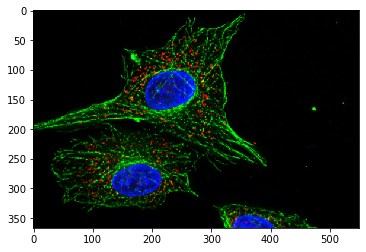


ORIGINAL IMAGE PROFILE:


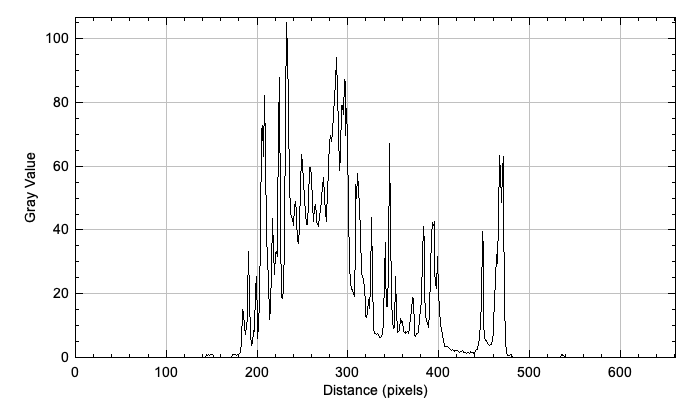

In [12]:
analysed_image = ij.py.active_image_plus()
print("\nORIGINAL IMAGE:")
ij.py.show(analysed_image)

print("\nORIGINAL IMAGE PROFILE:")
Image(f"{OUTPUT_path}")

By running the plugin we process the last active image on ImageJ. We can then compute the profile on the processed picture after save it and show it to screen.

In [13]:
plugin = 'Mean'
args_mean = { 
    'block_radius_x': 10,
    'block_radius_y': 10
}
ij.py.run_plugin(plugin, args_mean)

<java object 'org.scijava.script.ScriptModule'>

After running the plugin, the filtered image is active one. At this point, by running a macro we would modify this image. Also here we can see and display the image to screen by calling the *ij.py.active_image_plus()* command.

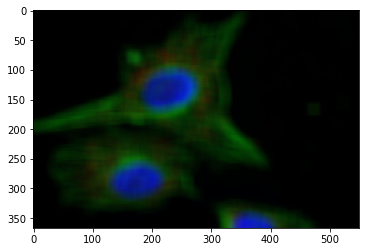

In [14]:
filtered = ij.py.active_image_plus()
ij.py.show(filtered)

**HOW TO SAVE:** To save this file from the notebook we need to convert the resulted image in a numpy array with *ij.py.from_java()* command and then write the file as .tif with the *tifffile.imwrite()* command. For this purpose we need to specify the destination path.

In [15]:
#Convert to numpy
numpy_filtered = ij.py.from_java(filtered)
print(type(numpy_filtered))

<class 'xarray.core.dataarray.DataArray'>


In [16]:
#Save with tifffile to IMAGES_dir so that we can use it for future processing
tosave_path_file = IMAGES_dir + "/image3_filtered.tif"
tifffile.imwrite(tosave_path_file, numpy_filtered, imagej=True) 

In [17]:
#Re-open the previous image as demonstration
saved_image = ij.io().open(tosave_path_file)

23:37:35.616 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - processor is INTEL_64 os.arch is x86_64
23:37:35.617 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is OSX_64 os.name is mac os x
23:37:35.618 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is OSX_64 os.name is mac os x
23:37:35.619 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is natives/osx_64/
23:37:35.619 [AWT-AppKit] DEBUG org.scijava.nativelib.BaseJniExtractor - mappedLib is libturbojpeg.dylib
23:37:35.621 [AWT-AppKit] DEBUG org.scijava.nativelib.BaseJniExtractor - Couldn't find resource natives/osx_64/libturbojpeg.dylib
23:37:35.622 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is osx_64/
23:37:35.623 [AWT-AppKit] DEBUG org.scijava.nativelib.BaseJniExtractor - mappedLib is libturbojpeg.dylib
23:37:35.625 [AWT-AppKit] DEBUG org.scijava.nativelib.BaseJniExtractor - Couldn't find r

[java.lang.Enum.toString] 23:37:35.616 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - processor is INTEL_64 os.arch is x86_64
[java.lang.Enum.toString] 23:37:35.617 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is OSX_64 os.name is mac os x
[java.lang.Enum.toString] 23:37:35.618 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is OSX_64 os.name is mac os x
[java.lang.Enum.toString] 23:37:35.619 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is natives/osx_64/
[java.lang.Enum.toString] 23:37:35.619 [AWT-AppKit] DEBUG org.scijava.nativelib.BaseJniExtractor - mappedLib is libturbojpeg.dylib
[java.lang.Enum.toString] 23:37:35.621 [AWT-AppKit] DEBUG org.scijava.nativelib.BaseJniExtractor - Couldn't find resource natives/osx_64/libturbojpeg.dylib
[java.lang.Enum.toString] 23:37:35.622 [AWT-AppKit] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is osx_64/
[java.lang.

23:37:35.837 [AWT-AppKit] DEBUG loci.formats.in.LeicaSCNReader - XML parsing failed
java.io.IOException: null
	at loci.common.xml.XMLTools.parseXML(XMLTools.java:559)
	at loci.common.xml.XMLTools.parseXML(XMLTools.java:533)
	at loci.common.xml.XMLTools.parseXML(XMLTools.java:504)
	at loci.formats.in.LeicaSCNReader.isThisType(LeicaSCNReader.java:109)
	at loci.formats.ImageReader.isThisType(ImageReader.java:254)
	at io.scif.bf.BioFormatsFormat$Checker.isFormat(BioFormatsFormat.java:371)
	at io.scif.services.DefaultFormatService.getFormatList(DefaultFormatService.java:341)
	at io.scif.services.DefaultFormatService.getFormat(DefaultFormatService.java:316)
	at io.scif.services.DefaultDatasetIOService.canOpen(DefaultDatasetIOService.java:82)
	at io.scif.io.DatasetIOPlugin.supportsOpen(DatasetIOPlugin.java:64)
	at org.scijava.io.IOService.getOpener(IOService.java:55)
	at org.scijava.io.DefaultIOService.open(DefaultIOService.java:66)
Caused by: org.xml.sax.SAXParseException: Content is not all

[java.lang.Enum.toString] 23:37:35.837 [AWT-AppKit] DEBUG loci.formats.in.LeicaSCNReader - XML parsing failed
java.io.IOException: null
	at loci.common.xml.XMLTools.parseXML(XMLTools.java:559)
	at loci.common.xml.XMLTools.parseXML(XMLTools.java:533)
	at loci.common.xml.XMLTools.parseXML(XMLTools.java:504)
	at loci.formats.in.LeicaSCNReader.isThisType(LeicaSCNReader.java:109)
	at loci.formats.ImageReader.isThisType(ImageReader.java:254)
	at io.scif.bf.BioFormatsFormat$Checker.isFormat(BioFormatsFormat.java:371)
	at io.scif.services.DefaultFormatService.getFormatList(DefaultFormatService.java:341)
	at io.scif.services.DefaultFormatService.getFormat(DefaultFormatService.java:316)
	at io.scif.services.DefaultDatasetIOService.canOpen(DefaultDatasetIOService.java:82)
	at io.scif.io.DatasetIOPlugin.supportsOpen(DatasetIOPlugin.java:64)
	at org.scijava.io.IOService.getOpener(IOService.java:55)
	at org.scijava.io.DefaultIOService.open(DefaultIOService.java:66)
Caused by: org.xml.sax.SAXParseExc

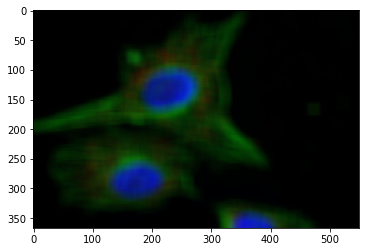

In [18]:
ij.py.show(saved_image)

Now, to compute the profile on the filtered picture we can use the previous macro (macro_OpenProfile) and just change the Input/Output arguments. 

With this example I showed how we can re-use a macro by **personalising the filename_in and filename_out**.

In [19]:
args_IO['filename_in'] = "image3_filtered.tif"
args_IO['filename_out'] = "image3_filtered_profile.png"

result = ij.py.run_macro(macro_OpenProfile, args_IO)

INPUT_path = result.getOutput("path_in")
OUTPUT_path = result.getOutput("path_out")

print("\nINPUT file:", INPUT_path)
print("\nOUTPUT file:", OUTPUT_path)

[INFO] script:macro.ijm = [[path_in, path_out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image3_filtered.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image3_filtered_profile.png]]

INPUT file: /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image3_filtered.tif

OUTPUT file: /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image3_filtered_profile.png


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[path_in, path_out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image3_filtered.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image3_filtered_profile.png]]


In [20]:
filtered_image = ij.io().open(f"{INPUT_path}")


FILTERED IMAGE:


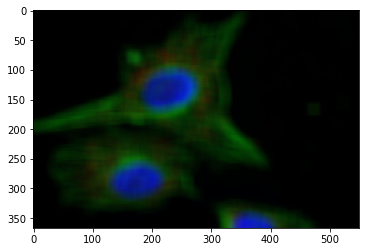


FILTERED IMAGE PROFILE:


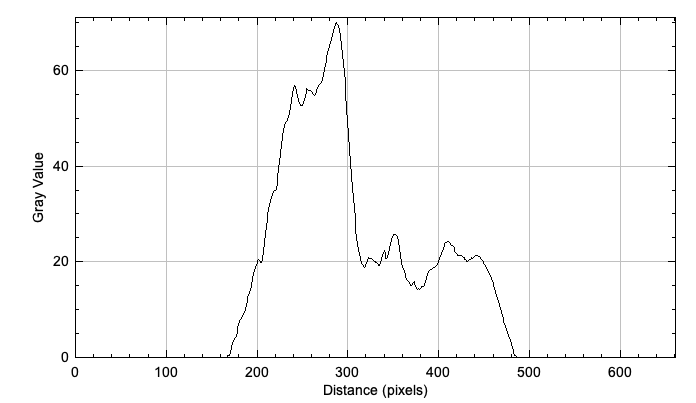

In [21]:
print("\nFILTERED IMAGE:")
ij.py.show(filtered_image)

print("\nFILTERED IMAGE PROFILE:")
Image(f"{OUTPUT_path}")

***

### Build generalize functions out of Macros and PyimageJ
Thanks to pyhton is it possible to combine all the code shown above and make a generalised function that can do the job on the background and run ImageJ tasks just by calling it. Below I show an example of a function that Open an image and computes the profile of this image along the diagonal (from upper-left to bottom_right).

In [22]:
#MACRO OPEN AND SHOW IMAGE & PROFILE

def OpenAndProfile(INPUT_filename = "", path_in = "", path_out = ""):
  
  #CREATE files/folders
    #FOR SPECIFIED dir_in dir_out
    if len(INPUT_filename) == 0:
        INPUT_filename = path_in.rsplit('/', 1)[1]
        path_in = path_in.rsplit('/', 1)[0]
    
    #FOR SPECIFIED INPUT_filename in IMAGE folder (located in the same directory of the notebook) 
    cwd = os.getcwd() #Get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES"
    if len(path_out) == 0:
        path_out = cwd + "/RESULTS"
    
    OUTPUT_filename = INPUT_filename.rsplit('.', 1)[0] + "_profile.png"

    try:
        os.mkdir(path_out)  
    except FileExistsError:
        print("This output directory already exist.")
    print("\n")
    print("The images are imported from: ", path_in)
    print("The results are exported in: ", path_out)
    print("\n\n")
    
    #INITIALIZE arguments
    args_IO = {
    'dir_in': f"{path_in}",          
    'dir_out' : f"{path_out}",
    'filename_in' : f"{INPUT_filename}",
    'filename_out' : f"{OUTPUT_filename}"
    }
    
    #DEFINE ImageJ macro commands
    macro_OpenProfile = """
    
//DEFINE IO
#@ String dir_in
#@ String dir_out
#@ String filename_in
#@ String filename_out
#@output String in
#@output String out

in = dir_in + "/" + filename_in
out = dir_out + "/" + filename_out

//OPEN IMAGE
open(in)

//MAKE AND SAVE PROFILE ON ORIGINAL IMAGE
H = getHeight();
W = getWidth();
makeLine(0, 0, W, H, 5);
run("Plot Profile");
saveAs(".png", out);

//SELECT IMAGE FOR NEXT STEP 
selectWindow(filename_in);

"""
    
    #RUN the Macro
    macro_results = ij.py.run_macro(macro_OpenProfile, args_IO)
    
    #GET the results
    INPUT_path = macro_results.getOutput("in")
    OUTPUT_path = macro_results.getOutput("out")
    results = (INPUT_path, OUTPUT_path)
    
    #PRINT the results
    image = ij.py.active_image_plus()
    print("\nIMAGE:")
    ij.py.show(image, cmap = "gray")
    
    profile = io.imread(f"{OUTPUT_path}")
    print("\nIMAGE PROFILE:")
    ij.py.show(profile, cmap = "gray")
    
    
    #Return the input_file name. This is important because it will be needed to name and save the resulted images
    global filename
    filename = INPUT_filename 

By default, the function takes in input an image of user choise present in the IMAGE folder and output the result in the RESULT folder.

This output directory already exist.


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/RESULTS



[INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image1.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image1_profile.png]]

IMAGE:


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image1.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image1_profile.png]]


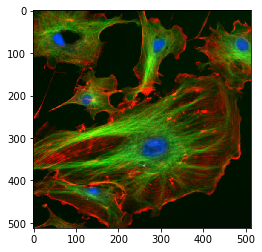


IMAGE PROFILE:


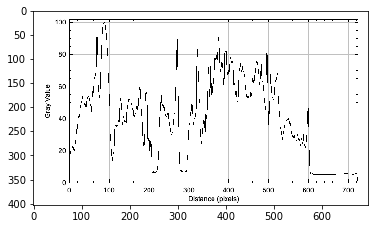

In [23]:
#RUN THE FUNCTION
OpenAndProfile("image1.tif")

Unfortunatly, the profile plot cannot be displayed from the funtion with the command *Image()* and the *ij.py.show()* does not allow the user to modify the arguments (to increase the size of the image) of the implemented function *pyplot.show()* the documentation is available [here](https://github.com/imagej/pyimagej/blob/master/imagej/__init__.py#:~:text=return%20coords-,def,-show(self%2C%20image)

#### RUN OpenAndProfile() on any images

In the example shown below I show how to run this function on any image. The requested arguments are *path_in*: the path of the file I want to work on, and *path_out:* the path of directory where I want to save the results (in this case the profile plot).

This output directory already exist.


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
The results are exported in:  /Users/nicolascristini/Desktop/Results



[INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image2.jpeg, /Users/nicolascristini/Desktop/Results/image2_profile.png]]

IMAGE:


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image2.jpeg, /Users/nicolascristini/Desktop/Results/image2_profile.png]]


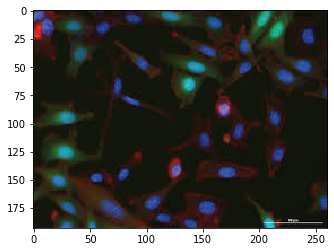


IMAGE PROFILE:


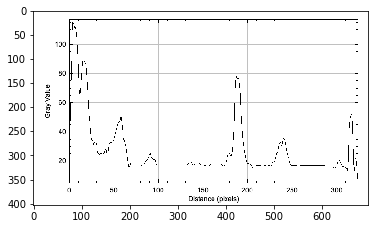

In [24]:
#EXAMPLE:
OpenAndProfile(path_in = "/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image2.jpeg", 
               path_out = "/Users/nicolascristini/Desktop/Results")

At this point We can process our image with a sequence of python functions embedding different macro commands. 
All the ImageProcessing functions are included in separate anonymous module [here](link).

The Image opened with the function OpenAndProfile() is still the active image and it can be easily called from the notebook. All the following functions will have effect on the active image and they will left the resulted image as the last selected one.

In [25]:
# Before going to the following section it good practice to close all the images and windows open in the background 
# In this way we are sure that only one image enters the processingso pipeline
ij.py.run_macro("""
close("*");      
run("Close All");
""") 

<java object 'org.scijava.script.ScriptModule'>

***

## Image Processing
**By using multiple embedded python function we can process and get results from an image. For example I will perform a filtering, processing, segmentation and analyse particles on a fluorescent nuclei image**

**OPEN IMAGE AND GET PROFILE**

To semplificate the use of ImageJ from the notebook it is possibile to use pre-compiled functions that works as the one showed above to compute the open an image and comute the image profile along the diagonal line. The set of function is located in the ProcessingFunction.py module. The list of functions:
* Open() 
* Profile()
* Filter()
* SubtractBackground()
* Threshold()
* Count()

To show how the functions work, I will include the code in this notebook and proceed with the image analysis.

In [26]:
def Open(INPUT_filename = "", path_in = ""):
    
# make variables  available to all functions and to name and save the following resulted images

# 1 - CREATE path for input/outputt

    # FOR SPECIFIED INPUT_filename in IMAGE folder - located in the directory of the notebook -
    if len(INPUT_filename) == 0:
        INPUT_filename = path_in.rsplit('/', 1)[1]
        path_in = path_in.rsplit('/', 1)[0] + "/"
    
    #FOR SPECIFIED INPUT_filename in IMAGE folder (located in the same directory of the notebook) 
    cwd = os.getcwd() #Get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES/"
        print("\n")
        print("The images are imported from: ", path_in)

# 2 - ImageJ macro text

    # INITIALIZE dictionary with arguments
    args_IO = {
    'dir_in' :f"{path_in}",
    'filename_in' : f"{INPUT_filename}"}

    macro_Open = """
    #@ String dir_in
    #@ String filename_in
    #@output String in

    // CREATE OUTPUT
    in = dir_in + filename_in

    // OPEN IMAGE
    open(in)
    """
    
    # RUN the Macro
    macro_results = ij.py.run_macro(macro_Open, args_IO)

    # PRINT the results
    opened_image = ij.py.active_image_plus()
    ij.py.show(opened_image, cmap = "gray")
    print("\nIMAGE ⬆︎")
    
    print("\nImage path:", f"{path_in + INPUT_filename}")
    
    # MAKE variables available for following steps
    global filename
    filename = INPUT_filename



The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/


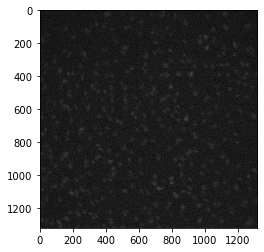


IMAGE ⬆︎

Image path: /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4.tif


In [27]:
Open("image4.tif")

In [28]:
def Profile(path_in = "", path_out= ""):
    # 1 - Multiple working situations:
    #a) The image is left activated by the the Open() function, filename is a global variable.
    
    INPUT_filename = filename
    OUTPUT_filename = INPUT_filename.rsplit('.', 1)[0] + "_profile.png" # create OUTPUT_filename

    #b) The profile is computed on a non open image. INPUT_filename of path_in is specified
    
    # MISSING (WORK WITH CLASSES TO IMPLEMENT THIS OPTION)
    
    cwd = os.getcwd() #Get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES"
    if len(path_out) == 0:
        path_out = cwd + "/RESULTS"

    try:
        os.mkdir(path_out)  
    except FileExistsError:
        print("The output directory already exist.")

    # PRINT file/folder info
    print("---------------------------------------------------")
    print("\n")
    print("The images are imported from: ", path_in)
    print("INPUT_filename:", INPUT_filename)
    
    print("\n")
    
    print("The results are exported in: ", path_out)
    print("OUTPUT_filename:", OUTPUT_filename)
    print("\n")
    print("---------------------------------------------------")

# 2 - ImageJ macro profile text

    # INITIALIZE dictionary with arguments
    args_IO = {
    'dir_in' :f"{path_in}",
    'dir_out' : f'{path_out}',
    'filename_in' : f'{INPUT_filename}',
    'filename_out' : f'{OUTPUT_filename}'
    }

    # ImageJ macro commands
    macro_Profile = """
    
//DEFINE IO
#@ String dir_in
#@ String dir_out
#@ String filename_in
#@ String filename_out
#@output String in
#@output String out

title = getTitle();

in = dir_in + "/" + filename_in
out = dir_out + "/" + filename_out

//MAKE AND SAVE PROFILE ON ORIGINAL IMAGE

H = getHeight();                            // get image size
W = getWidth();
makeLine(0, 0, W, H, 5);                    // make line with
run("Plot Profile");                        // make Profile
saveAs(".png", out);
run("Close");

// SELECT THE INPUT IMAGES AS LAST COMMAND FOR THE FOLLOWING STEPS
selectWindow(title);
"""

    #RUN the Macro
    macro_results = ij.py.run_macro(macro_Profile, args_IO)

    #GET the results
    INPUT_path = macro_results.getOutput("in")
    OUTPUT_path = macro_results.getOutput("out")
    results = (INPUT_path, OUTPUT_path)

    profile = io.imread(f"{OUTPUT_path}")
    ij.py.show(profile, cmap = "gray")
    print("IMAGE PROFILE ⬆︎")
    
    # Select the previous active image to reselect it at the end of the function for next steps!
    image = ij.py.active_image_plus()


The output directory already exist.
---------------------------------------------------


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4.tif


The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/RESULTS
OUTPUT_filename: image4_profile.png


---------------------------------------------------
[INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_profile.png]]


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_profile.png]]


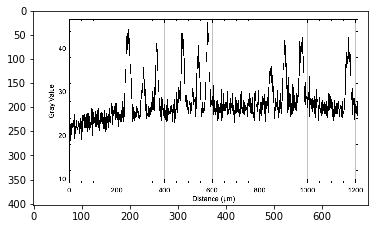

IMAGE PROFILE ⬆︎


In [29]:
Profile()

From the profile showed above we can see that in the image there is a lot of noise and background that must be deleted in order to perform a better analysis. **The purpose of the following pipeline is to identify the nuclei and to count them.**

**FILTER with MEAN**

In [30]:
def Filter(path_in = "", path_out = ""):
    global filename, image
# This functions apply the mean filter plug-in with default radius = 2 pixels.
# the resulted filtered image will be shown to screen and saved to the IMAGES folder.

# 1 - Multiple working situations:
    #a) The image is left activated by the previous function, filename is a global variable.

    INPUT_filename = filename
    OUTPUT_filename = INPUT_filename.rsplit('.', 1)[0] + "_filtered.tif"
    
    # get the IMAGES folder path to save the resulted image
    cwd = os.getcwd() # get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES"
    path_image_out = path_in + "/" + OUTPUT_filename

    # PRINT file/folder info
    print("---------------------------------------------------")
    print("\n")
    print("The images are imported from: ", path_in)
    print("INPUT_filename:", INPUT_filename)
    
    print("\n")
    
    print("The results are exported in: ", path_image_out)
    print("OUTPUT_filename:", OUTPUT_filename)
    print("\n")
    print("---------------------------------------------------")


# 2 - RUN the plugin
    plugin = 'Mean'
    args_mean = {
    'block_radius_x': 4,
    'block_radius_y': 4}

    ij.py.run_plugin(plugin, args_mean)

    # SAVE the resulted filtered image
    filtered = ij.py.active_image_plus()
    numpy_filtered = ij.py.from_java(filtered)
    tifffile.imwrite(path_image_out, numpy_filtered, imagej=True)

    # PRINT the results
    ij.py.show(filtered, cmap = "gray")
    print("\nIMAGE ⬆︎")

    # ACTIVATE resulted image 
    filtered = ij.py.active_image_plus()
    # SAVE resulted filename
    filename = OUTPUT_filename

---------------------------------------------------


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4.tif


The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_filtered.tif
OUTPUT_filename: image4_filtered.tif


---------------------------------------------------


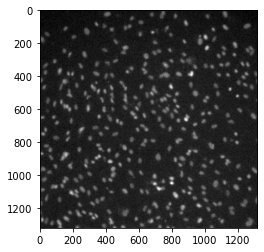


IMAGE ⬆︎


In [31]:
Filter()

The output directory already exist.
---------------------------------------------------


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4_filtered.tif


The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/RESULTS
OUTPUT_filename: image4_filtered_profile.png


---------------------------------------------------
[INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_filtered.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_filtered_profile.png]]


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_filtered.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_filtered_profile.png]]


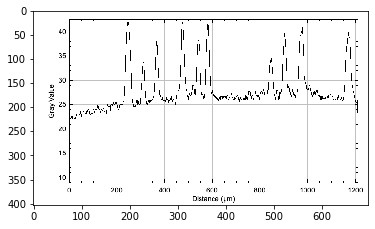

IMAGE PROFILE ⬆︎


In [32]:
Profile()

**SUBTRACT BACKGROUND**
from documentation[here](https://imagej.net/plugins/rolling-ball-background-subtraction):

This plugin tries to correct for uneven illuminated background by using a “rolling ball” algorithm.

A local background value is determined for every pixel by averaging over a very large ball around the pixel. This value is hereafter subtracted from the original image, hopefully removing large spatial variations of the background intensities. The radius should be set to at least the size of the largest object that is not part of the background.

Subtract the background from a nuceli image. The profile plot can show us the amount of noise and background that can be resolved with the application of the right plugin. The first step is to open the image with the macro_OpenProfile.

In [33]:
def SubtractBackground(path_in = "", path_out = ""):
    global filename

# This functions apply a ImageJ macro to use the rolling subtract background plug in with default 50 pixel diameter.
# the resulted subtracted image will be shown to screen and saved to the IMAGES folder.

# 1 - Multiple working situations:
    #a) The image is left activated by the previous function, filename is a global variable.

    INPUT_filename = filename
    OUTPUT_filename = INPUT_filename.rsplit('_', 1)[0] + "_subtracted.tif"
    path_image_out = path_in + "/" + OUTPUT_filename

    # get the IMAGES folder path to save the resulted image
    cwd = os.getcwd() # get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES"
    
    path_image_out = path_in + "/" + OUTPUT_filename

    # PRINT file/folder info
    print("---------------------------------------------------")
    print("\n")
    print("The images are imported from: ", path_in)
    print("INPUT_filename:", INPUT_filename)
    
    print("\n")
    
    print("The results are exported in: ", path_image_out)
    print("OUTPUT_filename:", OUTPUT_filename)
    print("\n")
    print("---------------------------------------------------")


# 2 - ImageJ macro subtract background text
    # INITIALIZE dictionary with arguments

    macro_SubtractBackground = """
// macro commands

run("Enhance Contrast...", "saturated=0.35");               // Run the default contract
run("Subtract Background...", "rolling=50 disable");        // Run the default contract
"""
    ij.py.run_macro(macro_SubtractBackground)

    #SAVE the resulted subtracted image
    subtracted = ij.py.active_image_plus()
    numpy_subtracted = ij.py.from_java(subtracted)
    tifffile.imwrite(path_image_out, numpy_subtracted, imagej=True)

    #PRINT the results
    ij.py.show(subtracted, cmap = "gray")
    print("\nIMAGE ⬆︎")
    
    # ACTIVATE resulted image 
    subtracted = ij.py.active_image_plus()

    # SAVE resulted filename
    filename = OUTPUT_filename

---------------------------------------------------


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4_filtered.tif


The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_subtracted.tif
OUTPUT_filename: image4_subtracted.tif


---------------------------------------------------


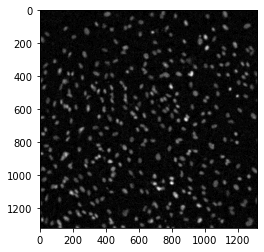


IMAGE ⬆︎


In [34]:
SubtractBackground()

The output directory already exist.
---------------------------------------------------


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4_subtracted.tif


The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/RESULTS
OUTPUT_filename: image4_subtracted_profile.png


---------------------------------------------------
[INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_subtracted.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_subtracted_profile.png]]


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_subtracted.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_subtracted_profile.png]]


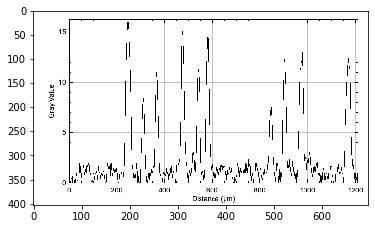

IMAGE PROFILE ⬆︎


In [35]:
Profile()

As shown in the profile, now the pics of intensity are much more higlighted and so we can move to the next step tht consist in the application of the threshold

In [36]:
def Threshold(path_in = "", path_out = ""):
    global filename
# This functions apply a ImageJ macro to applly the Threshold. Now setted as Li.
# the resulted thresholded image will be shown to screen and saved to the IMAGES folder.
# In the following macro, I had to save the image from the macro-text becuase the method used before gave an ERROR

# 1 - Multiple working situations:
    #a) The image is left activated by the previous function, filename is a global variable.

    INPUT_filename = filename
    OUTPUT_filename = INPUT_filename.rsplit('_', 1)[0] + "_thresholded.tif"
    path_image_out = path_in + "/" + OUTPUT_filename

    # get the IMAGES folder path to save the resulted image
    cwd = os.getcwd() # get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES"
    path_image_out = path_in + "/" + OUTPUT_filename

    # PRINT file/folder info
    print("---------------------------------------------------")
    print("INPUT:")
    print("The images are imported from: ", path_in)
    print("INPUT_filename:", INPUT_filename)
    
    print("\n")
    print("OUTPUT:")
    print("The results are exported in: ", path_image_out)
    print("OUTPUT_filename:", OUTPUT_filename)
    print("---------------------------------------------------")

    args_IO = {
    'path_out' : f'{path_image_out}',
    }
    
    macro_Threshold = """
//DEFINE IO
#@ String path_out

// RUN threshold
setAutoThreshold("Default dark");
setOption("BlackBackground", true);
run("Convert to Mask");
run("Watershed");
saveAs("tiff", path_out);
"""
    ij.py.run_macro(macro_Threshold, args_IO)
    
    #SAVE the resulted subtracted image
    thresholded = ij.py.active_image_plus()
    numpy_thresholded = ij.py.from_java(thresholded)
    tifffile.imwrite(path_image_out, numpy_thresholded, imagej=True)

    #PRINT the results
    ij.py.show(thresholded, cmap = "gray")
    print("\nIMAGE ⬆︎")
    
    # SAVE resulted filename
    filename = OUTPUT_filename

---------------------------------------------------
INPUT:
The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4_subtracted.tif


OUTPUT:
The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_thresholded.tif
OUTPUT_filename: image4_thresholded.tif
---------------------------------------------------


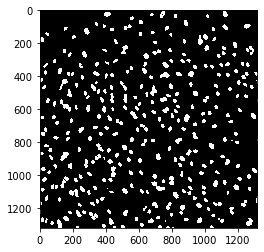


IMAGE ⬆︎


In [37]:
Threshold()

The output directory already exist.
---------------------------------------------------


The images are imported from:  /Users/nicolascristini/IPAN-Project/IPAN/IMAGES
INPUT_filename: image4_thresholded.tif


The results are exported in:  /Users/nicolascristini/IPAN-Project/IPAN/RESULTS
OUTPUT_filename: image4_thresholded_profile.png


---------------------------------------------------
[INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_thresholded.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_thresholded_profile.png]]


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[in, out], [/Users/nicolascristini/IPAN-Project/IPAN/IMAGES/image4_thresholded.tif, /Users/nicolascristini/IPAN-Project/IPAN/RESULTS/image4_thresholded_profile.png]]


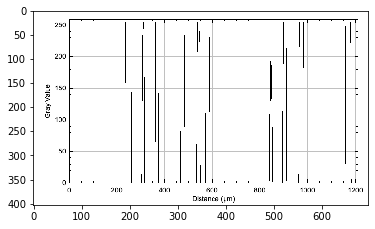

IMAGE PROFILE ⬆︎


In [38]:
Profile()

At the end of this processing steps we obtain a binary image with only white (pixel value = 255) object corresponding to our nuclei and black (pixel value = 0) background.
It is possible now to measure the number of white object by applying the "measuring partciles". The macro will be incorporated in a function *Count()*

**ANALYSE PARTICLES**

In [39]:
def Count(path_in = "", path_out = ""):
    global filename
# This functions use the *Analyse Particles* in a ImageJ macro to applly to count the number of objects in the picture.
# the Result table will show the feature selected in *Set Measurements* In this case we are going to analysis: 
# area, circularity, AR ratio. The resulted table will be saved in the RESULTS folder.
# Besides that, the table will be displayed by using pandas. 

# 1 - Multiple working situations:
    #a) The image is left activated by the previous function, filename is a global variable.

    INPUT_filename = filename
    OUTPUT_filename = INPUT_filename.rsplit('_', 1)[0] + "_data.csv"

    # get the IMAGES folder path to save the resulted image
    cwd = os.getcwd() # get current directory
    if len(path_in) == 0:
        path_in = cwd + "/IMAGES"
    if len(path_out) == 0:
        path_out = cwd + "/RESULTS"
        
    path_data_out = path_out + "/" + OUTPUT_filename

    # PRINT file/folder info
    print("---------------------------------------------------")
    print("INPUT:")
    print("The images are imported from: ", path_in)
    print("INPUT_filename:", INPUT_filename)
    
    print("\n")
    print("OUTPUT:")
    print("The results are exported in: ", path_out)
    print("OUTPUT_filename:", OUTPUT_filename)
    print("---------------------------------------------------")

    args_IO = {
    'path_out' : f'{path_data_out}',
    }

    macro_Count = """
// DEFINE IO
#@ String path_out

// RUN THE MEASUREMENTS
title = getTitle()

run("Set Measurements...", "area shape display redirect=None decimal=3");
run("Analyze Particles...", "size=20-Infinity pixel circularity=0.10-1.00 show=Outlines display exclude clear summarize in_situ");
saveAs("Results", path_out);
"""
    
    ij.py.run_macro(macro_Count, args_IO)
    print("\nThe data are saved as:\n", path_data_out)

    #PRINT the results
    return path_data_out

In [40]:
%%capture
resulted_data = Count()

 	Label	Area	Circ.	AR	Round	Solidity
1	image4_thresholded.tif	188.013	0.797	1.127	0.887	0.918
2	image4_thresholded.tif	375.181	0.843	1.466	0.682	0.952
3	image4_thresholded.tif	401.376	0.863	1.458	0.686	0.953
4	image4_thresholded.tif	147.453	0.927	1.082	0.924	0.948
5	image4_thresholded.tif	175.338	0.861	1.446	0.692	0.939
6	image4_thresholded.tif	190.125	0.784	1.224	0.817	0.922
7	image4_thresholded.tif	166.043	0.724	1.300	0.769	0.921
8	image4_thresholded.tif	170.690	0.838	1.385	0.722	0.936
9	image4_thresholded.tif	300.821	0.846	1.546	0.647	0.951
10	image4_thresholded.tif	235.755	0.871	1.279	0.782	0.936
11	image4_thresholded.tif	183.365	0.816	1.518	0.659	0.918
12	image4_thresholded.tif	392.926	0.805	1.607	0.622	0.944
13	image4_thresholded.tif	141.960	0.594	1.189	0.841	0.846
14	image4_thresholded.tif	176.605	0.875	1.137	0.879	0.922
15	image4_thresholded.tif	345.183	0.805	1.647	0.607	0.940
16	image4_thresholded.tif	192.238	0.884	1.092	0.916	0.935
17	image4_thresholded.tif	205.335	0.741	1.72

145	image4_thresholded.tif	182.098	0.790	1.654	0.605	0.927
146	image4_thresholded.tif	201.533	0.820	1.525	0.656	0.931
147	image4_thresholded.tif	299.131	0.836	1.595	0.627	0.948
148	image4_thresholded.tif	186.323	0.854	1.417	0.706	0.942
149	image4_thresholded.tif	192.660	0.881	1.313	0.761	0.937
150	image4_thresholded.tif	124.215	0.881	1.389	0.720	0.925
151	image4_thresholded.tif	210.405	0.851	1.687	0.593	0.949
152	image4_thresholded.tif	208.715	0.787	1.812	0.552	0.918
153	image4_thresholded.tif	200.688	0.846	1.439	0.695	0.931
154	image4_thresholded.tif	197.730	0.805	1.429	0.700	0.922
155	image4_thresholded.tif	10.985	0.743	1.018	0.983	0.732
156	image4_thresholded.tif	303.778	0.819	1.527	0.655	0.938
157	image4_thresholded.tif	172.803	0.861	1.145	0.874	0.924
158	image4_thresholded.tif	178.295	0.914	1.181	0.847	0.946
159	image4_thresholded.tif	220.123	0.762	1.732	0.577	0.935
160	image4_thresholded.tif	196.040	0.853	1.243	0.805	0.932
161	image4_thresholded.tif	383.631	0.814	1.558	0.642	0.94

311	image4_thresholded.tif	183.365	0.850	1.306	0.766	0.930
312	image4_thresholded.tif	189.280	0.792	1.772	0.564	0.920
313	image4_thresholded.tif	175.760	0.815	1.652	0.605	0.927
314	image4_thresholded.tif	230.263	0.747	1.282	0.780	0.892
315	image4_thresholded.tif	325.326	0.858	1.315	0.760	0.949
316	image4_thresholded.tif	353.211	0.779	1.282	0.780	0.933
317	image4_thresholded.tif	184.633	0.864	1.353	0.739	0.935
318	image4_thresholded.tif	65.910	0.874	1.139	0.878	0.904
319	image4_thresholded.tif	177.873	0.797	1.272	0.786	0.917
320	image4_thresholded.tif	185.055	0.846	1.633	0.612	0.935
321	image4_thresholded.tif	120.835	0.732	1.526	0.655	0.885
322	image4_thresholded.tif	197.308	0.830	1.220	0.819	0.924
323	image4_thresholded.tif	202.378	0.858	1.610	0.621	0.931
324	image4_thresholded.tif	378.138	0.610	1.617	0.618	0.899
325	image4_thresholded.tif	363.773	0.684	2.232	0.448	0.927
326	image4_thresholded.tif	196.885	0.840	1.707	0.586	0.943
327	image4_thresholded.tif	204.068	0.778	1.719	0.582	0.92

The .csv file has been saved in the output folder and now we can finally use pandas to import the dataset and work on the results.

In [41]:
#Import libraries for data management and visualization
#import seaborn as sns
import pandas as pd

#Clean dataframe
Data = pd.read_csv(resulted_data, header = 0, sep=',', encoding='latin-1', index_col=0)
Data = Data.drop("Label", axis = 1)
Data.rename(columns={'Circ.': 'Circularity'}, inplace=True)
Data_summary = Data.describe()

print(Data)
print("\n", Data_summary)
print("\nTotal number of nuclei:\t", Data.shape[0])

        Area  Circularity     AR  Round  Solidity
                                                 
1    188.013        0.797  1.127  0.887     0.918
2    375.181        0.843  1.466  0.682     0.952
3    401.376        0.863  1.458  0.686     0.953
4    147.453        0.927  1.082  0.924     0.948
5    175.338        0.861  1.446  0.692     0.939
..       ...          ...    ...    ...       ...
346  192.238        0.859  1.123  0.890     0.941
347  327.438        0.809  1.629  0.614     0.952
348   30.843        0.907  1.109  0.902     0.918
349  182.520        0.846  1.377  0.726     0.926
350  176.605        0.886  1.294  0.773     0.943

[350 rows x 5 columns]

              Area  Circularity          AR      Round    Solidity
count  350.000000   350.000000  350.000000  350.00000  350.000000
mean   222.729077     0.809577    1.475269    0.69996    0.926463
std     84.786011     0.080956    0.278850    0.12062    0.024208
min     10.985000     0.518000    1.018000    0.36400    0.7

***
### Import functions from a module.py
Now that the functions run correctly it is possible to collect them in a module.py and import the required one to run the image analysis. 

An example of image processing by using the function imported from the module.py is shown in the following notebook:
03 - Working with IPAN module pt.3 

***
***